# Final Project

**EMA 550**: Astrodynamics

In [1]:
%matplotlib widget

In [2]:
from utils.lamberts import *
from utils.propagator import *
from utils.constants import *
from utils.ephemerides import *
from utils.orbital_elements import *
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
plt.ion()

_bold = '\033[1m'
_reset = '\033[0m'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Some utility constants
_moon_sma = pv_to_moe(pv=moon_ephemeris.pv0)[1]
_lunar_orbit_limits = [
    (-1*_moon_sma, _moon_sma),
    (-1*_moon_sma, _moon_sma),
    (-1*_moon_sma, _moon_sma)
]
_leo_limits = [
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3),
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3),
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3)
]
_lunar_limits = [
    (-1*MOON.radius - 50000e3, MOON.radius + 50000e3),
    (-1*MOON.radius - 50000e3, MOON.radius + 50000e3),
    (-1*MOON.radius - 50000e3, MOON.radius + 50000e3)
]

## Problem Parameters

In [4]:
# Time of flight
time_of_flight = 6*24*60*60 # 6 days
launch_time = Time("2022-04-16").unix

# Initial LEO Orbit
initial_leo_coe = make_coe(
    e=0.0,
    a=EARTH.radius+300e3,
    i=EARTH.obiquity,
    raan=0.0,
    arg_peri=0.0,
    true_anom=-2.8)
initial_leo_ephemeris = Ephemeris(
    pv=pv_from_moe(moe=initial_leo_coe),
    t=launch_time,
    central_body=EARTH)

In [5]:
print(f"{_bold}Initial LEO orbit{_reset}")
print_moe(moe=initial_leo_coe)

# Final orbit (for reference)
print()
print(f"{_bold}Moon's Orbit{_reset}")
print_moe(moe=pv_to_moe(pv=moon_ephemeris.get_pv(t=launch_time)))

Initial LEO orbit
Eccentricity:    0.0
SMA:             6678000.0 m
Inclination:     23.45 deg
Right Ascension: 0.0 deg
Arg Perigee:     0.0 deg
True Anom:       -160.42818263663048 deg

Moon's Orbit
Eccentricity:    0.058182277595110674
SMA:             386167592.8135836 m
Inclination:     26.902672276788117 deg
Right Ascension: 9.180293108652695 deg
Arg Perigee:     246.58616807187158 deg
True Anom:       300.0365457615386 deg


## Lunar Transfer

In [6]:
# Determine where the moon will be at intercept
moon_intercept_pv = moon_ephemeris.get_pv(t=launch_time+time_of_flight)

# Get the pv vector for the transfer orbit
transfer_pv1, transfer_pv2 = lamberts(
    r1_vec=initial_leo_ephemeris.get_pv(t=launch_time)[:3],
    r2_vec=moon_intercept_pv[:3],
    dt=time_of_flight,
    central_body=EARTH)
transfer_ephemeris = Ephemeris(pv=transfer_pv1, t=launch_time, central_body=EARTH)

# Determine the time at which the we enter the lunar sphere of influence
times, transfer_traj = transfer_ephemeris.get_traj(t0=launch_time, t1=launch_time+time_of_flight)
lunar_soi_entry_time = times[0]
for i in range(times.shape[0]):
    pv = transfer_traj[i,:]
    if(np.linalg.norm(pv[:3] - moon_ephemeris.get_pv(t=times[i])[:3]) < MOON.soi):
        lunar_soi_entry_time = times[i]
        break

# Get the lunar reference frame ephemeris
lunar_transfer_ephemeris = Ephemeris.earth_to_lunar(
    eci_ephemeris=transfer_ephemeris,
    moon_ephemeris=moon_ephemeris,
    t = lunar_soi_entry_time)

In [7]:
print(f"{_bold}Transfer Orbit (ECI Frame){_reset}")
print_moe(moe=pv_to_moe(pv=transfer_pv1))

print(f"{_bold}Transfer Orbit (Lunar Frame){_reset}")
print_moe(moe=pv_to_moe(pv=lunar_transfer_ephemeris.get_pv(t=lunar_soi_entry_time), central_body=MOON))

Transfer Orbit (ECI Frame)
Eccentricity:    0.9854427574300849
SMA:             191480664.42522898 m
Inclination:     27.208062147741952 deg
Right Ascension: 2.8974622685483955 deg
Arg Perigee:     96.942771886091 deg
True Anom:       100.00861744264489 deg
Transfer Orbit (Lunar Frame)
Eccentricity:    1.003039201763845
SMA:             -6127412.82688566 m
Inclination:     26.93360908015114 deg
Right Ascension: 10.012299989273767 deg
Arg Perigee:     159.17458863729183 deg
True Anom:       184.88946210470797 deg


## Plot Trajectory

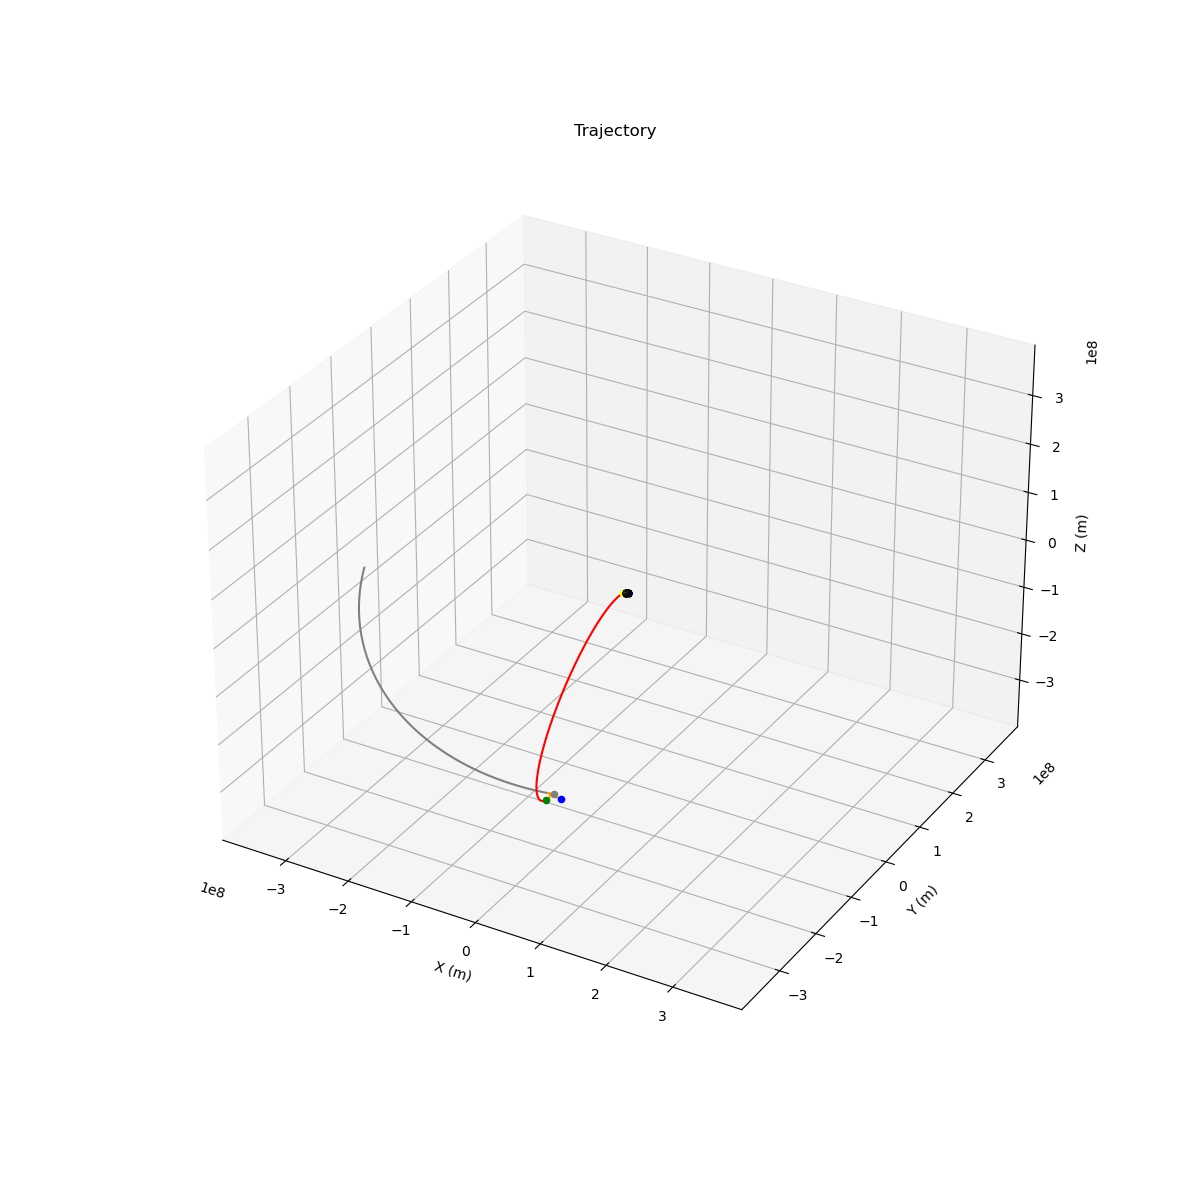

In [8]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_lunar_orbit_limits[0],
    ylim=_lunar_orbit_limits[1],
    zlim=_lunar_orbit_limits[2])
plot_earth(
    ax=ax,
    label="Earth")

ax.set_title("Trajectory")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
#ax.legend()

##### interesting bits #####
moon_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Moon",
    pathColor="grey",
    pointColor="grey")
initial_leo_ephemeris.plot(
    ax=ax,
    t0=launch_time-1000,
    t1=launch_time,
    label="Initial Orbit",
    pathColor="blue",
    pointColor="yellow")
transfer_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=lunar_soi_entry_time,
    label="Transfer Orbit",
    pathColor="red",
    pointColor="green")
lunar_transfer_ephemeris.plot_lunar_in_eci(
    ax=ax,
    t0=lunar_soi_entry_time,
    t1=launch_time+time_of_flight,
    label="Transfer Orbit",
    moon_ephemeris=moon_ephemeris,
    pathColor="orange",
    pointColor="blue")

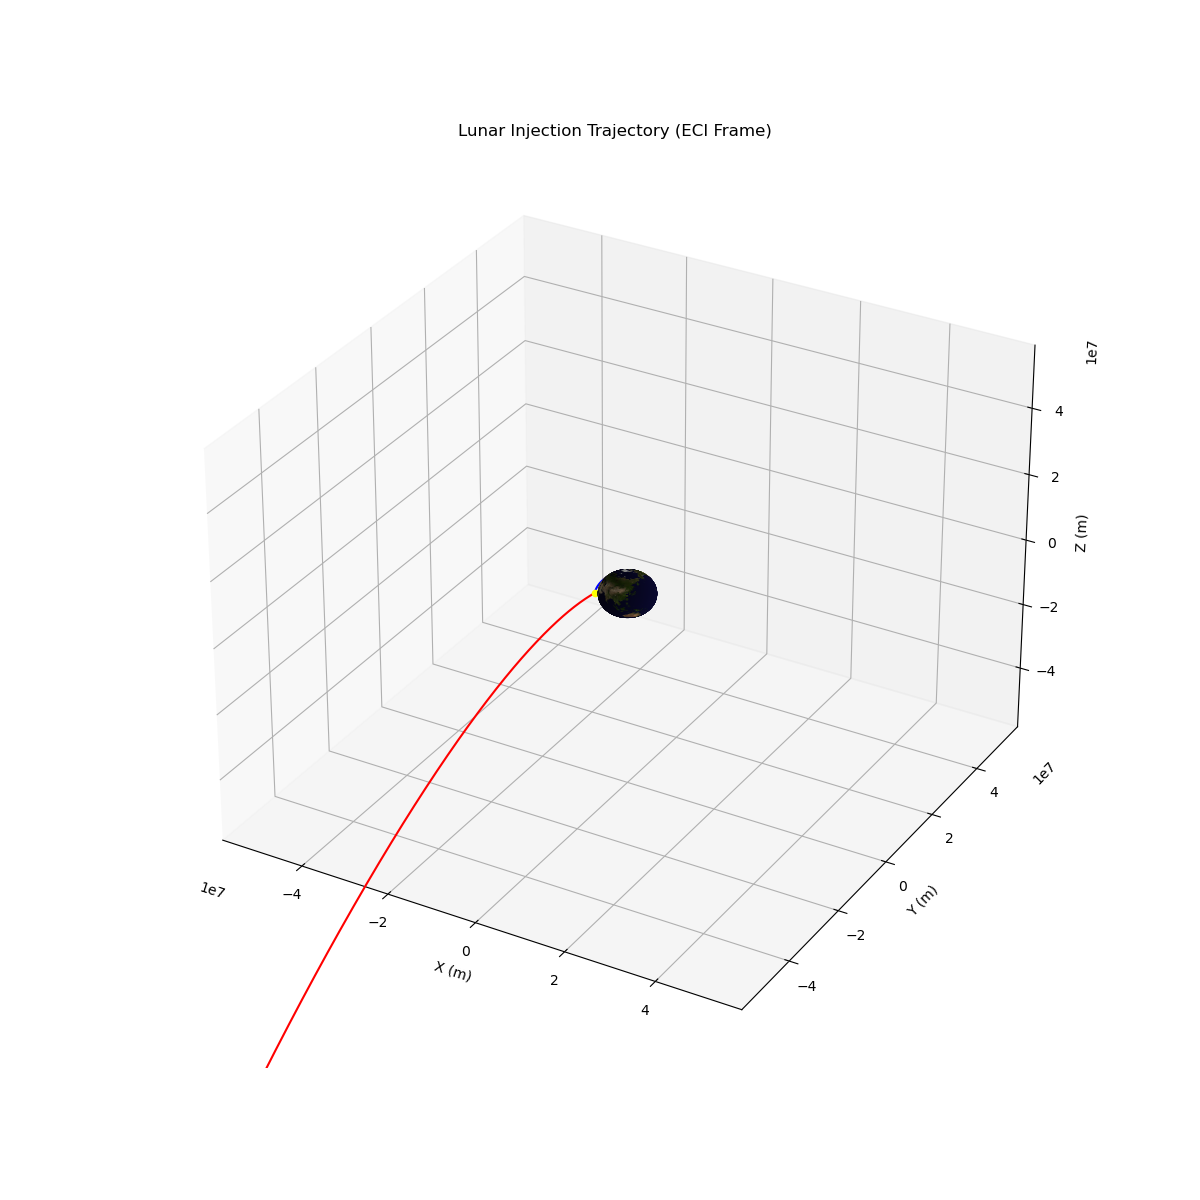

In [9]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_leo_limits[0],
    ylim=_leo_limits[1],
    zlim=_leo_limits[2])
plot_earth(
    ax=ax,
    label="Earth")

ax.set_title("Lunar Injection Trajectory (ECI Frame)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.legend()

##### interesting bits #####
initial_leo_ephemeris.plot(
    ax=ax,
    t0=launch_time-1000,
    t1=launch_time,
    label="Initial Orbit",
    pathColor="blue",
    pointColor="yellow")
transfer_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Transfer Orbit",
    pathColor="red",
    pointColor="green")

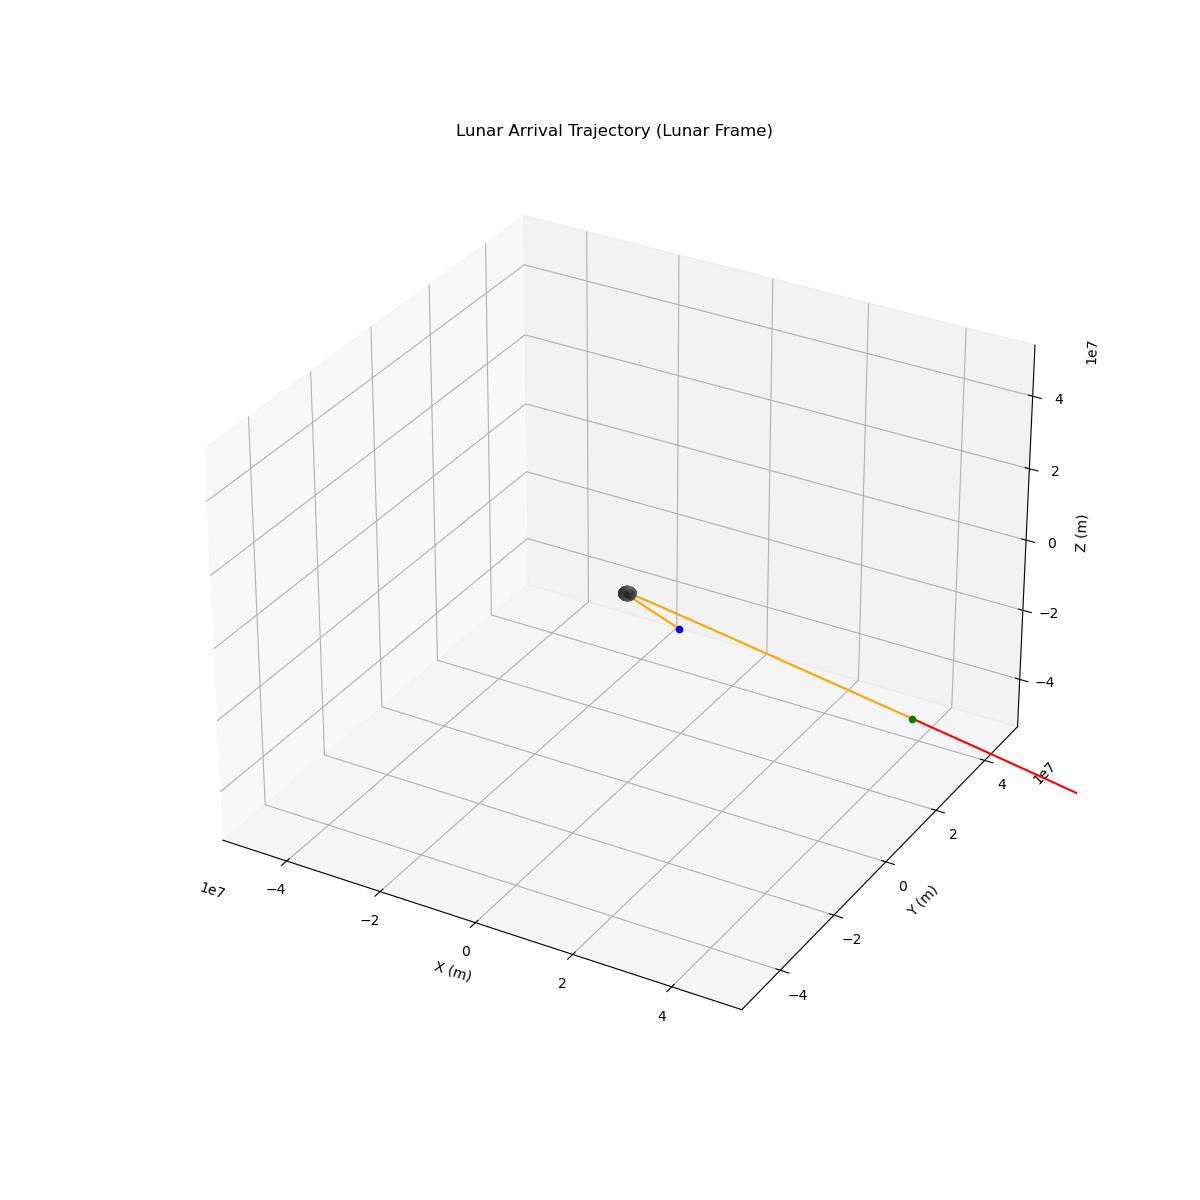

In [10]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_lunar_limits[0],
    ylim=_lunar_limits[1],
    zlim=_lunar_limits[2])
plot_moon(
    ax=ax,
    label="Moon")

ax.set_title("Lunar Arrival Trajectory (Lunar Frame)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.legend()

##### interesting bits #####
transfer_ephemeris.plot_eci_in_lunar(
    ax=ax,
    t0=launch_time,
    t1=lunar_soi_entry_time,
    label="Transfer Orbit",
    moon_ephemeris=moon_ephemeris,
    pathColor="red",
    pointColor="green")
# Note that we dont use plot_lunar_in_eci() because this is in the lunar frame
lunar_transfer_ephemeris.plot(
    ax=ax,
    t0=lunar_soi_entry_time,
    t1=launch_time+time_of_flight,
    label="Transfer Orbit",
    pathColor="orange",
    pointColor="blue")